<a href="https://colab.research.google.com/github/kjg331/Lecture-Sequences-Time-Series-and-Prediction/blob/main/daily_minimum_temperatures_participation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 You will use a dataset from Jason Brownlee, author of the amazing MachineLearningMastery.com site and who has shared lots of datasets at
https://github.com/jbrownlee/Datasets
. It’s a dataset of daily minimum temperatures in the city of Melbourne, Australia measured from 1981 to 1990.  Your task is to parse the data from a CSV, create a time series and build a prediction model from it.

In [ ]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TEMPERATURES_CSV = '/content/drive/MyDrive/Colab Notebooks/Lecture_note_Sequences, Time Series and Prediction/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



## Parsing the raw data
A couple of things to note:

- You should omit the first line as the file contains headers.
- There is no need to save the data points as numpy arrays, regular lists is fine.
- To read from csv files use `csv.reader` by passing the appropriate arguments.
- `csv.reader` returns an iterable that returns each row in every iteration. So the temperature can be accessed via row[1] and the date can be discarded.
- The `times` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `temperatures` list.
- The values of the `temperatures` should be of `float` type. You can use Python's built-in `float` function to ensure this.

In [ ]:
def parse_data_from_file(filename):

  times = []
  temperatures = []

  with open(filename) as csvfile:

    reader = csv.reader(csvfile, delimiter=',')

    # Skip the first line
    next(reader)

    # Append row and sunspot number to lists
    for row in reader:
      times.append(row[0])
      temperatures.append(float(row[1]))

    # Convert lists to numpy arrays
    times = np.array(times)
    temperatures = np.array(temperatures)

  return times, temperatures

In [ ]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    # Check if there are more than two series to plot
    if type(y) is tuple:
      # Loop over the y elements
      for y_curr in y:
        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)
    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)
    # Label the y-axis
    plt.ylabel(ylabel)
    # Set the legend
    if legend:
      plt.legend(legend)
    # Set the title
    plt.title(title)
    # Overlay a grid on the graph
    plt.grid(True)
    # Draw the graph on screen
    plt.show()

The next cell will use your function to compute the `times` and `temperatures` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

<Figure size 1000x600 with 0 Axes>

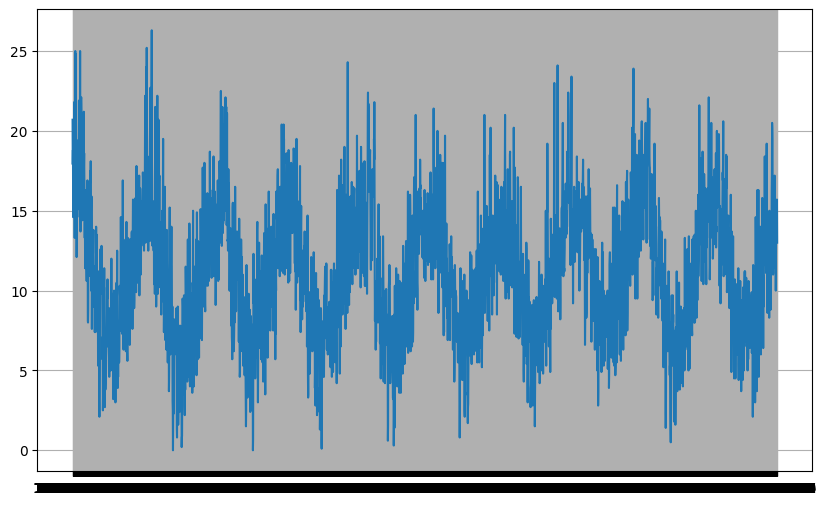

In [ ]:
# Test function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = '/content/drive/MyDrive/Colab Notebooks/Lecture_note_Sequences, Time Series and Prediction/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = int(len(temperatures)*0.8)
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

* Seasonality: The data shows a clear seasonal pattern, with temperatures peaking in the summer and bottoming out in the winter. This is likely due to the city's location in the Northern Hemisphere.

* Trend: There is also a slight upward trend in the data over time. This could be due to a number of factors, such as climate change, urban heat island effect, or changes in the way the data is collected. This is shown by the gradual increase in the baseline of the temperature data over time.

* Autocorrelation: The data is also autocorrelated, meaning that the temperature on any given day is correlated with the temperature on the previous day. This is likely due to the fact that it takes time for the temperature to change. This can be seen in the way that the data points tend to cluster together, and how a high temperature on one day is often followed by another high temperature on the next day.

Here are some additional features that could be analyzed:

* Cyclicity: The data may also show some cyclicity, such as a daily or weekly cycle. This could be due to factors such as the sun's rotation or the city's weather patterns.

* Stationarity: The data may or may not be stationary. Stationary data means that the statistical properties of the data, such as the mean and variance, do not change over time. Non-stationary data can be more difficult to analyze. I cannot determine if the data is stationary from this image.

* Outliers: The data may also contain outliers, which are data points that are far from the rest of the data. Outliers can be caused by a number of factors, such as measurement errors or unusual weather events. There don't appear to be any outliers in this data.

## Processing the data

Those are the helper functions to `train_val_split` and `windowed_dataset` .

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define your layer architecture. Just as in last week's assignment you will do the layer definition and compilation in two separate steps. Begin by completing the `create_uncompiled_model` function below.

This is done so you can reuse your model's layers for the learning rate adjusting and the actual training.

Hint:

- `Lambda` layers are not required.
- Use a combination of `Conv1D` and `LSTM` layers followed by `Dense` layers

In [ ]:
import tensorflow as tf

def create_uncompiled_model():
    # 1. Create the model
    model = tf.keras.models.Sequential([
        # 2. Add 1D Convolutional Layer
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                               strides=1,
                               activation='relu',
                               padding='causal',
                               input_shape=[None, 1]),
        # 3. Add LSTM Layer (returning sequences)
        tf.keras.layers.LSTM(64, return_sequences=True),
        # 4. Add LSTM Layer
        tf.keras.layers.LSTM(64),
        # 5. Add Fully Connected Layer
        tf.keras.layers.Dense(30, activation='relu'),
        # 6. Add Fully Connected Layer
        tf.keras.layers.Dense(30, activation='relu'),
        # 7. Add Output Layer
        tf.keras.layers.Dense(1),
        # 8. Add Lambda Layer for Scaling the Output (8a. Scale the output by 30, considering the temperature values are in the range of 0 to 30 degrees)
        tf.keras.layers.Lambda(lambda x: x * 30)
    ])

    return model

You can test your model with the code below. If you get an error, it's likely that your model is returning a sequence. You can indeed use an LSTM with `return_sequences=True` but you have to feed it into another layer that generates a single prediction. You can review the lectures or the previous ungraded labs to see how that is done.

In [ ]:
# Test your uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):

    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)

# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (32, 64)...
1/1 [==============================] - 1s 1s/step
Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate

As you saw in the lectures, you can leverage Tensorflow's callbacks to dynamically vary the learning rate before doing the actual training. This can be helpful in finding what value works best with your model. Note that this is only one way of finding the best learning rate. There are other techniques for hyperparameter optimization but it is outside the scope of this course.

For the optimizers you can try out:

- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD with a momentum of 0.9

In [ ]:
import tensorflow as tf

def adjust_learning_rate(dataset):
    # 1. Create the model
    model = create_uncompiled_model()

    # 2. Define the learning rate scheduling callback
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))

    # 3. Choose the optimizer (Using Adam optimizer)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6)

    # 4. Compile the model
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])  # 4a. Set the loss function (Huber) and evaluation metric (MAE)

    # 5. Train the model using the dataset
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [ ]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
90/90 [==============================] - 15s 104ms/step - loss: 9.8347 - mae: 10.3333 - lr: 1.0000e-06
Epoch 2/100
90/90 [==============================] - 8s 84ms/step - loss: 9.0604 - mae: 9.5590 - lr: 1.1220e-06
Epoch 3/100
90/90 [==============================] - 8s 85ms/step - loss: 8.2893 - mae: 8.7860 - lr: 1.2589e-06
Epoch 4/100
90/90 [==============================] - 7s 75ms/step - loss: 7.4712 - mae: 7.9674 - lr: 1.4125e-06
Epoch 5/100
90/90 [==============================] - 8s 90ms/step - loss: 6.5854 - mae: 7.0799 - lr: 1.5849e-06
Epoch 6/100
90/90 [==============================] - 9s 94ms/step - loss: 5.6106 - mae: 6.0987 - lr: 1.7783e-06
Epoch 7/100
90/90 [==============================] - 8s 80ms/step - loss: 4.6562 - mae: 5.1389 - lr: 1.9953e-06
Epoch 8/100
90/90 [==============================] - 8s 89ms/step - loss: 3.9318 - mae: 4.4101 - lr: 2.2387e-06
Epoch 9/100
90/90 [==============================] - 7s 74ms/step - loss: 3.3459 - mae: 3.8202 - lr: 

(1e-06, 0.01, 1.0, 10.0)

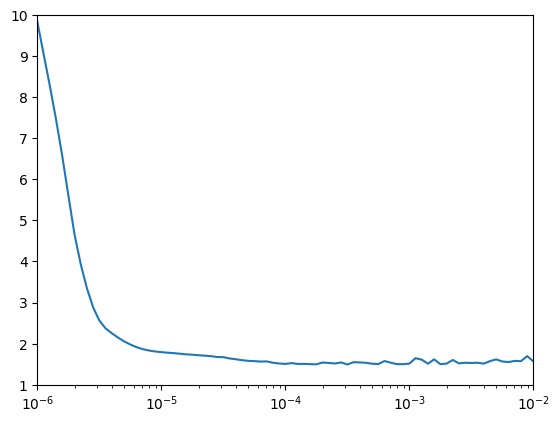

In [ ]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1e-2, 1, 10])

# General observations:

1. The x-axis shows the learning rate in logarithmic scale, ranging from 10^-4 to 10^-1.
2. The y-axis shows the mean absolute error (Loss) on a linear scale.

# Key points:

1. Overall, the loss decreases as the learning rate increases, until a certain point. This is typical behavior, as a higher learning rate allows the model to update its weights more quickly and adapt to the training data more effectively.
2. However, there can be a point of diminishing returns where increasing the learning rate too much leads to overfitting and higher loss.
3. Curves show that the loss is started to be flatted around 10^-4, so for the model I will start llearning rate from 10^-4

## Compiling the model
Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hints:

- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: loss: nan - mae: nan it is very likely that your network is suffering from exploding gradients. This is a common problem if you used SGD as optimizer and set a learning rate that is too high. If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.

In [ ]:
def create_model():
    # This function creates a neural network model for a specific task.

    # Create an instance of the neural network model using a function called create_uncompiled_model().
    model = create_uncompiled_model()

    # Define an optimizer for the model. Here, Adam optimizer is used with a specific learning rate.
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    # Compile the model. Compilation involves specifying the loss function, optimizer, and metrics to monitor during training.
    # Huber loss is used as the loss function, which is less sensitive to outliers in data compared to Mean Squared Error (MSE).
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])  # "mae" stands for Mean Absolute Error, used as a metric.

    # Return the compiled model.
    return model

In [ ]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
90/90 [==============================] - 13s 88ms/step - loss: 2.3756 - mae: 2.8345
Epoch 2/50
90/90 [==============================] - 7s 78ms/step - loss: 1.7531 - mae: 2.2046
Epoch 3/50
90/90 [==============================] - 9s 99ms/step - loss: 1.6704 - mae: 2.1188
Epoch 4/50
90/90 [==============================] - 8s 91ms/step - loss: 1.6384 - mae: 2.0869
Epoch 5/50
90/90 [==============================] - 7s 76ms/step - loss: 1.5645 - mae: 2.0094
Epoch 6/50
90/90 [==============================] - 8s 92ms/step - loss: 1.5471 - mae: 1.9879
Epoch 7/50
90/90 [==============================] - 8s 89ms/step - loss: 1.5793 - mae: 2.0251
Epoch 8/50
90/90 [==============================] - 7s 76ms/step - loss: 1.5429 - mae: 1.9867
Epoch 9/50
90/90 [==============================] - 7s 76ms/step - loss: 1.5137 - mae: 1.9558
Epoch 10/50
90/90 [==============================] - 8s 92ms/step - loss: 1.5055 - mae: 1.9472
Epoch 11/50
90/90 [==============================] - 7s 77

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [ ]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.



## Faster model forecasts

This faster approach uses batches of data.

The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:
- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [ ]:
def model_forecast(model, series, window_size):
    # This function generates forecasts using the provided model and input series data.

    # Create a TensorFlow dataset from the input series.
    ds = tf.data.Dataset.from_tensor_slices(series)

    # Convert the dataset into a windowed dataset with the specified window_size.
    # The window moves by one element at each step and drop_remainder=True ensures all windows have the same size.
    ds = ds.window(window_size, shift=1, drop_remainder=True)

    # Convert each window into a batch of tensors.
    ds = ds.flat_map(lambda w: w.batch(window_size))

    # Batch the dataset with a batch size of 32 and prefetch one batch at a time.
    ds = ds.batch(32).prefetch(1)

    # Use the model to predict the forecast for the dataset.
    forecast = model.predict(ds)

    # Return the forecast generated by the model.
    return forecast

113/113 [==============================] - 4s 39ms/step


<Figure size 1000x600 with 0 Axes>

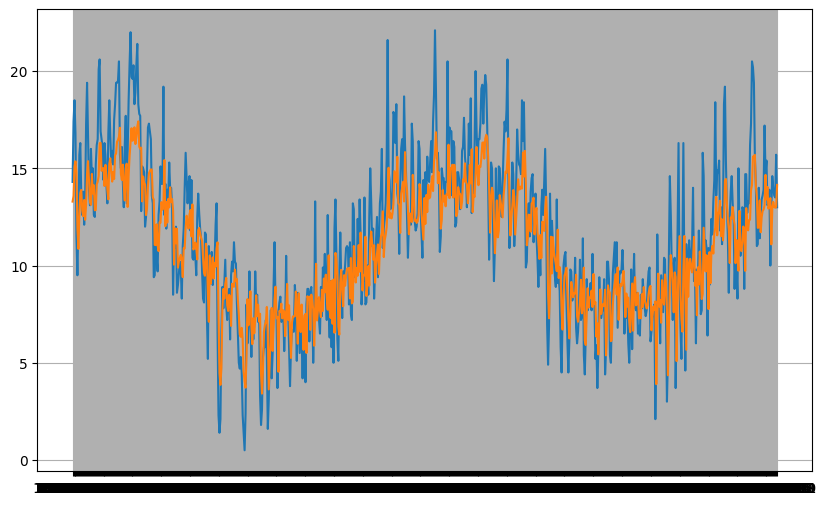

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the results
plt.figure(figsize=(10, 6))
plot_series(time_valid, (series_valid, rnn_forecast))

In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.33, mae: 1.83 for forecast


Mse and MAE is quite low, however when see the graph, the spark is far lower than the original dataset. Let's analyze the mae and loos per epoch and tune paramters.

<Figure size 1000x600 with 0 Axes>

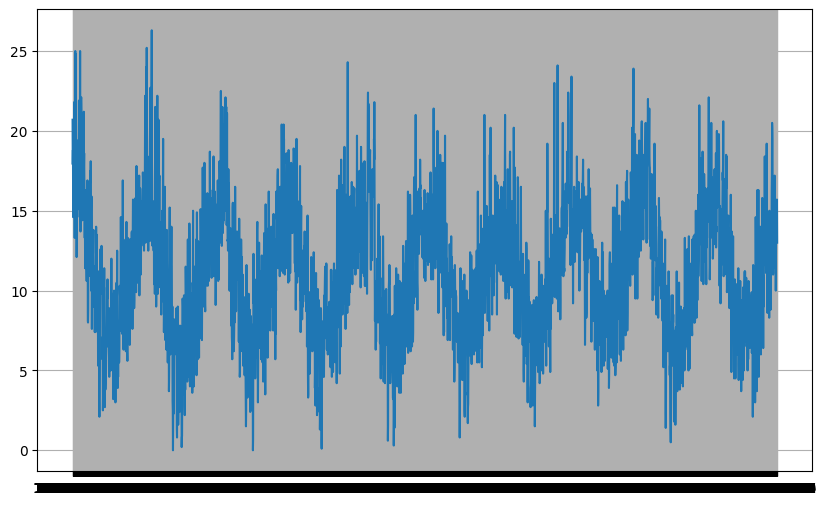

In [ ]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = '/content/drive/MyDrive/Colab Notebooks/Lecture_note_Sequences, Time Series and Prediction/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = int(len(temperatures)*0.8)
    WINDOW_SIZE = 365
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [ ]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
90/90 [==============================] - 13s 87ms/step - loss: 4.5229 - mae: 4.9931
Epoch 2/50
90/90 [==============================] - 8s 84ms/step - loss: 1.8301 - mae: 2.2803
Epoch 3/50
90/90 [==============================] - 7s 71ms/step - loss: 1.7687 - mae: 2.2194
Epoch 4/50
90/90 [==============================] - 7s 71ms/step - loss: 1.7370 - mae: 2.1871
Epoch 5/50
90/90 [==============================] - 8s 86ms/step - loss: 1.7164 - mae: 2.1644
Epoch 6/50
90/90 [==============================] - 7s 72ms/step - loss: 1.6573 - mae: 2.1043
Epoch 7/50
90/90 [==============================] - 8s 87ms/step - loss: 1.6150 - mae: 2.0607
Epoch 8/50
90/90 [==============================] - 7s 71ms/step - loss: 1.5894 - mae: 2.0359
Epoch 9/50
90/90 [==============================] - 7s 71ms/step - loss: 1.5623 - mae: 2.0067
Epoch 10/50
90/90 [==============================] - 7s 75ms/step - loss: 1.5633 - mae: 2.0069
Epoch 11/50
90/90 [==============================] - 8s 87

103/103 [==============================] - 15s 137ms/step


<Figure size 1000x600 with 0 Axes>

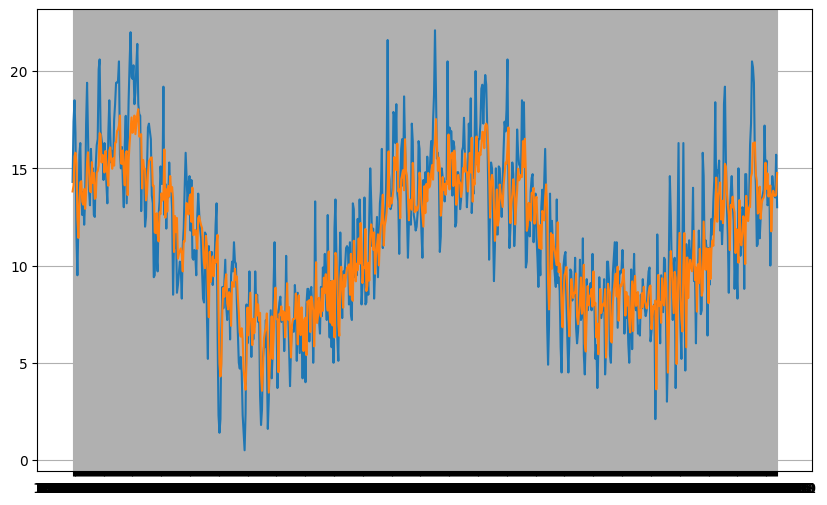

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the results
plt.figure(figsize=(10, 6))
plot_series(time_valid, (series_valid, rnn_forecast))

In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 4.92, mae: 1.75 for forecast


<Figure size 1000x600 with 0 Axes>

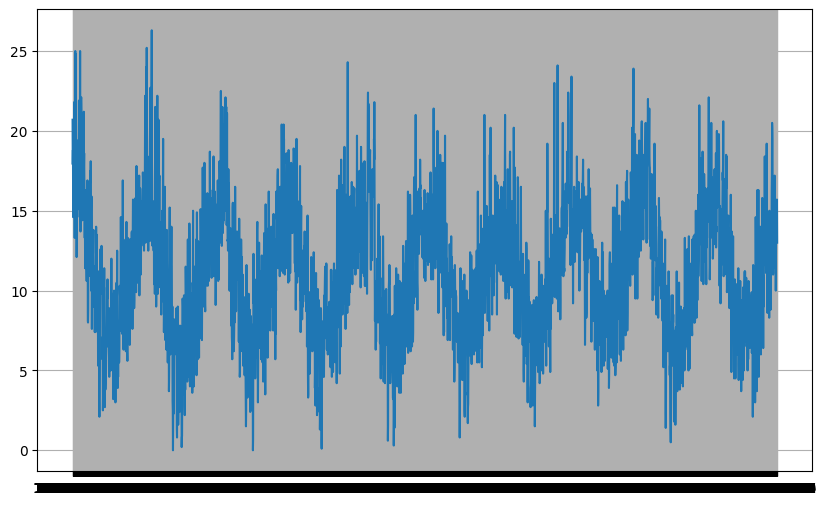

In [ ]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = '/content/drive/MyDrive/Colab Notebooks/Lecture_note_Sequences, Time Series and Prediction/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = int(len(temperatures)*0.8)
    WINDOW_SIZE = 80
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [ ]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
90/90 [==============================] - 13s 86ms/step - loss: 2.3844 - mae: 2.8425
Epoch 2/50
90/90 [==============================] - 6s 70ms/step - loss: 1.7246 - mae: 2.1750
Epoch 3/50
90/90 [==============================] - 6s 69ms/step - loss: 1.6678 - mae: 2.1167
Epoch 4/50
90/90 [==============================] - 8s 84ms/step - loss: 1.6204 - mae: 2.0655
Epoch 5/50
90/90 [==============================] - 7s 77ms/step - loss: 1.6354 - mae: 2.0832
Epoch 6/50
90/90 [==============================] - 7s 74ms/step - loss: 1.5612 - mae: 2.0084
Epoch 7/50
90/90 [==============================] - 7s 81ms/step - loss: 1.5593 - mae: 2.0050
Epoch 8/50
90/90 [==============================] - 6s 70ms/step - loss: 1.5268 - mae: 1.9722
Epoch 9/50
90/90 [==============================] - 7s 74ms/step - loss: 1.5514 - mae: 1.9940
Epoch 10/50
90/90 [==============================] - 8s 85ms/step - loss: 1.5453 - mae: 1.9898
Epoch 11/50
90/90 [==============================] - 6s 70

112/112 [==============================] - 5s 39ms/step


<Figure size 1000x600 with 0 Axes>

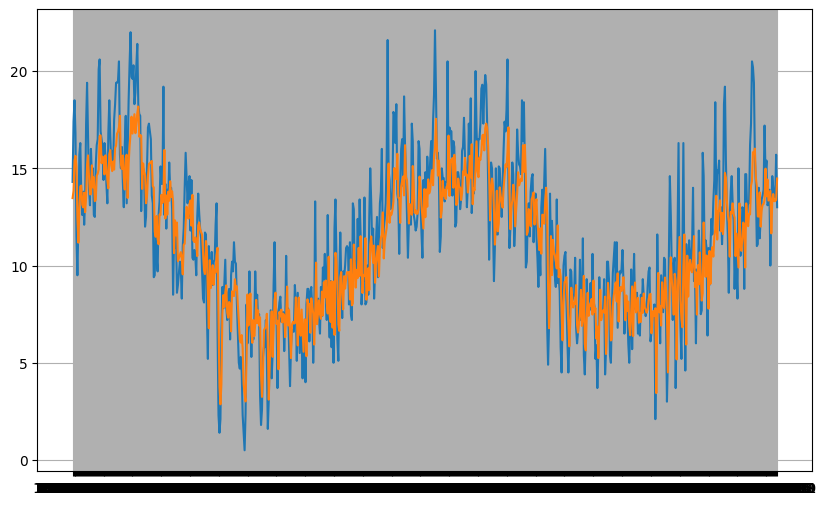

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the results
plt.figure(figsize=(10, 6))
plot_series(time_valid, (series_valid, rnn_forecast))

In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.03, mae: 1.77 for forecast
